<img src="http://www.cuhk.edu.hk/sci/essc/yang/img/cuhk_seismo_logo.png" width="300"  /> 

 
# Seisloc
#### A tool package for earthquake location process
Author: Jinping ZI  
Supervisor: Prof. Hongfeng YANG  
Affiliation: [Seismology Lab, ESSC, The Chinese University of Hong Kong](http://www.cuhk.edu.hk/sci/essc/yang/)
#### Advantages of this package
* **Easy set up**: setup by one command:  
~~~~
pip install seisloc
~~~~  
* **Easy to read**: Only using python scripts
* **High-efficiency**: Parallel processing, suitable for large dataset to be processed in workstation (e.g. Dense array data)
* **Convenient**: the file format for EQTransforer, VELEST, HYPOINVERSE, HypoDD and tomoDD could be easily done in one command

## Introduction
In this example, we will go through the dataset processing from basic raw data extracted from temporaray array.
Before run into processing, the necessary programmes are compiled automatically:
1) Sliding Window Cross-Correlation method(SCC),[Yang et al., 2009](https://doi.org/10.1785/0120090038)  



## Preparation
1. **Raw data**  
   Original data from temporary array in strcture: ./raw_data/sta_name/raw_files   
   Path: ./raw_data/sta_name/raw_files
2. **Station file**   
   Station file with net,sta,lon,lat,ele,label information.  
   Path: ./sta.txt

The later workflow including two parts: 1) Data quality control; 2) Data earthquake detection.

## Part.1 Raw Data Quality Control 

1. **Raw Data Veriation**
    * Check whether the network name and station name are correct with the station file, common problem for temporary stations
2. **Raw Data Split**
    * Split raw data by days, which is essential for ambient noise cross-correlation and the input for machine learning based detection
3. **Data Availability**
    * Using obspy-scan to get an overview
4. **Tele-Event Plot**
    * Using tele-event arrival time to verify time shift problem


In [2]:
## this code will be used if there are two subfolder such as data/sta/file. 
## for three subfolders/ follow code example/corrected data for this kind
# of directory. data/sta/2020/file

  Using cached autopep8-1.6.0-py2.py3-none-any.whl (45 kB)
  Using cached pycodestyle-2.8.0-py2.py3-none-any.whl (42 kB)
Note: you may need to restart the kernel to use updated packages.


In [1]:
import time
b_time=time.time()
import os
import re
import json
import obspy
from obspy import UTCDateTime,Stream
import subprocess
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from seisloc.sta import load_sta
from seisloc.utils import init_logger
import logging

init_logger("seisloc.log",file_level=logging.DEBUG,stream_level=logging.DEBUG)
logger = logging.getLogger()

class Params():                 
    def __init__(self):
        self.init = 0
params = Params()               # A dictionary to store parameters
params.root_path = os.getcwd()  # root working directory

# Load in station information
params.sta_file = os.path.join(params.root_path,"sta.txt")
params.eqt_sta_dict = {}    # specific station dictionary for eqtransformer
with open(params.sta_file,'r') as f:
    for line in f:
        line = line.rstrip()
        net,sta,_lon,_lat,_ele,_ = re.split(" +",line[:42])
        lon = float(_lon)
        lat = float(_lat)
        ele = float(_ele)
        params.eqt_sta_dict[sta]={}
        params.eqt_sta_dict[sta]["network"]=net
        params.eqt_sta_dict[sta]["channels"]=["BHN","BHE","BHZ"]
        params.eqt_sta_dict[sta]["coords"] = [lat,lon,ele]
f.close()
params.sta_list = params.eqt_sta_dict.keys()
e_time=time.time()
print(f"Time for this step is: ",e_time - b_time, " seconds")

Time for this step is:  6.770359992980957  seconds


## Plot Tele-Event

In [2]:
day_data="/NAS2/Abbas/Orignal_Data/Dense_Array_Orignal/Data"
files=[]
files1 = os.listdir(day_data)
for file in files1:
    if file.startswith("ML") and len(file) <5:
        files.append(file)
        print(file)

print(sorted(files))

ML12
ML80
ML73
ML27
ML69
ML37
ML59
ML18
ML08
ML35
ML26
ML33
ML41
ML09
ML06
ML14
ML56
ML64
ML71
ML77
ML74
ML17
ML05
ML43
ML29
ML32
ML72
ML58
ML67
ML04
ML07
ML28
ML46
ML79
ML70
ML54
ML57
ML50
ML42
ML68
ML55
ML62
ML10
ML01
ML48
ML63
ML52
ML44
ML51
ML34
ML60
ML36
ML15
ML53
ML75
ML61
ML22
ML31
ML03
ML20
ML40
ML66
ML02
ML78
ML13
ML65
ML39
ML49
ML47
ML76
ML21
ML11
ML38
ML16
ML45
ML19
['ML01', 'ML02', 'ML03', 'ML04', 'ML05', 'ML06', 'ML07', 'ML08', 'ML09', 'ML10', 'ML11', 'ML12', 'ML13', 'ML14', 'ML15', 'ML16', 'ML17', 'ML18', 'ML19', 'ML20', 'ML21', 'ML22', 'ML26', 'ML27', 'ML28', 'ML29', 'ML31', 'ML32', 'ML33', 'ML34', 'ML35', 'ML36', 'ML37', 'ML38', 'ML39', 'ML40', 'ML41', 'ML42', 'ML43', 'ML44', 'ML45', 'ML46', 'ML47', 'ML48', 'ML49', 'ML50', 'ML51', 'ML52', 'ML53', 'ML54', 'ML55', 'ML56', 'ML57', 'ML58', 'ML59', 'ML60', 'ML61', 'ML62', 'ML63', 'ML64', 'ML65', 'ML66', 'ML67', 'ML68', 'ML69', 'ML70', 'ML71', 'ML72', 'ML73', 'ML74', 'ML75', 'ML76', 'ML77', 'ML78', 'ML79', 'ML80']


In [8]:
from seisloc.wf.telewf2 import gen_tele_files

gen_tele_files(day_data,
                params.sta_file,
                min_mag=5.0,
                dist_range=[20,90],
                client_name="IRIS",
                taup_model="iasp91",
                tele_dir="tele_event")

2022-10-25 14:19:06,888-utils.py-INFO: Extract_set_info program launched...
2022-10-25 14:19:06,888-utils.py-INFO: Extract_set_info program launched...
2022-10-25 14:19:06,924-utils.py-INFO: Read in the existed setinfo.pkl and return
2022-10-25 14:19:06,924-utils.py-INFO: Read in the existed setinfo.pkl and return
2022-10-25 14:19:13,871-telewf2.py-INFO: Now process event: time:2020-06-13T21:08:30.503000Z mag:6.2
2022-10-25 14:19:13,871-telewf2.py-INFO: Now process event: time:2020-06-13T21:08:30.503000Z mag:6.2
2022-10-25 14:19:14,545-telewf2.py-INFO: Now process event: time:2020-06-13T15:51:24.069000Z mag:6.6
2022-10-25 14:19:14,545-telewf2.py-INFO: Now process event: time:2020-06-13T15:51:24.069000Z mag:6.6
2022-10-25 14:19:17,044-telewf2.py-INFO: Now process event: time:2020-06-10T04:29:21.220000Z mag:5.9
2022-10-25 14:19:17,044-telewf2.py-INFO: Now process event: time:2020-06-10T04:29:21.220000Z mag:5.9
2022-10-25 14:19:18,199-telewf2.py-INFO: Now process event: time:2020-06-09T17

In [9]:
time_problem_list = ["S007","Z193","Z163","Z013","Z010","Z011",
                     "Z062","Z073","Z080","Z091","Z100","Z110",
                     "Z111","Z123","Z130","Z131",'Z132','Z133',
                     'Z143','Z170','Z181','Z193','Z220',"Z202",
                     'Z222',"Z243"]+["Z070",'S005','Z092',"S003"]+["Z091","Z143","Z132","Z111",
             "Z230","Z050","Z030","Z140","Z321",
             "Z102","S004","S006","Z232"]
len(set(time_problem_list))

38

2022-10-25 14:19:51,840-telewf2.py-INFO: tele_event/20200530130623.tele
2022-10-25 14:19:51,840-telewf2.py-INFO: tele_event/20200530130623.tele
2022-10-25 14:19:51,843-telewf2.py-ERROR: mseed file not exits, set from_saved_wf False
2022-10-25 14:19:51,843-telewf2.py-ERROR: mseed file not exits, set from_saved_wf False


20200530130623.tele


100%|███████████████████████████████████████████| 76/76 [10:23<00:00,  8.20s/it]
2022-10-25 14:30:16,920-telewf2.py-INFO: tele_event/20200523230227.tele
2022-10-25 14:30:16,920-telewf2.py-INFO: tele_event/20200523230227.tele
2022-10-25 14:30:16,923-telewf2.py-ERROR: mseed file not exits, set from_saved_wf False
2022-10-25 14:30:16,923-telewf2.py-ERROR: mseed file not exits, set from_saved_wf False


20200523230227.tele


100%|███████████████████████████████████████████| 76/76 [08:51<00:00,  7.00s/it]
2022-10-25 14:39:10,624-telewf2.py-INFO: tele_event/20200508204530.tele
2022-10-25 14:39:10,624-telewf2.py-INFO: tele_event/20200508204530.tele
2022-10-25 14:39:10,625-telewf2.py-ERROR: mseed file not exits, set from_saved_wf False
2022-10-25 14:39:10,625-telewf2.py-ERROR: mseed file not exits, set from_saved_wf False


20200508204530.tele


100%|███████████████████████████████████████████| 76/76 [09:42<00:00,  7.66s/it]
2022-10-25 14:48:53,411-telewf2.py-INFO: tele_event/20200503115424.tele
2022-10-25 14:48:53,411-telewf2.py-INFO: tele_event/20200503115424.tele
2022-10-25 14:48:53,414-telewf2.py-ERROR: mseed file not exits, set from_saved_wf False
2022-10-25 14:48:53,414-telewf2.py-ERROR: mseed file not exits, set from_saved_wf False


20200503115424.tele


100%|███████████████████████████████████████████| 76/76 [08:58<00:00,  7.08s/it]
2022-10-25 14:57:53,236-telewf2.py-INFO: tele_event/20200530181347.tele
2022-10-25 14:57:53,236-telewf2.py-INFO: tele_event/20200530181347.tele
2022-10-25 14:57:53,238-telewf2.py-ERROR: mseed file not exits, set from_saved_wf False
2022-10-25 14:57:53,238-telewf2.py-ERROR: mseed file not exits, set from_saved_wf False


20200530181347.tele


100%|███████████████████████████████████████████| 76/76 [09:42<00:00,  7.67s/it]
2022-10-25 15:07:37,369-telewf2.py-INFO: tele_event/20200609045610.tele
2022-10-25 15:07:37,369-telewf2.py-INFO: tele_event/20200609045610.tele
2022-10-25 15:07:37,372-telewf2.py-ERROR: mseed file not exits, set from_saved_wf False
2022-10-25 15:07:37,372-telewf2.py-ERROR: mseed file not exits, set from_saved_wf False


20200609045610.tele


100%|███████████████████████████████████████████| 76/76 [08:57<00:00,  7.07s/it]
2022-10-25 15:16:35,256-telewf2.py-INFO: tele_event/20200506135356.tele
2022-10-25 15:16:35,256-telewf2.py-INFO: tele_event/20200506135356.tele
2022-10-25 15:16:35,258-telewf2.py-ERROR: mseed file not exits, set from_saved_wf False
2022-10-25 15:16:35,258-telewf2.py-ERROR: mseed file not exits, set from_saved_wf False


20200506135356.tele


100%|███████████████████████████████████████████| 76/76 [09:50<00:00,  7.78s/it]
2022-10-25 15:26:27,599-telewf2.py-INFO: tele_event/20200609171814.tele
2022-10-25 15:26:27,599-telewf2.py-INFO: tele_event/20200609171814.tele
2022-10-25 15:26:27,602-telewf2.py-ERROR: mseed file not exits, set from_saved_wf False
2022-10-25 15:26:27,602-telewf2.py-ERROR: mseed file not exits, set from_saved_wf False


20200609171814.tele


100%|███████████████████████████████████████████| 76/76 [09:04<00:00,  7.16s/it]
2022-10-25 15:35:32,519-telewf2.py-INFO: tele_event/20200507112119.tele
2022-10-25 15:35:32,519-telewf2.py-INFO: tele_event/20200507112119.tele
2022-10-25 15:35:32,521-telewf2.py-ERROR: mseed file not exits, set from_saved_wf False
2022-10-25 15:35:32,521-telewf2.py-ERROR: mseed file not exits, set from_saved_wf False


20200507112119.tele


100%|███████████████████████████████████████████| 76/76 [08:49<00:00,  6.96s/it]
2022-10-25 15:44:22,640-telewf2.py-INFO: tele_event/20200418092418.tele
2022-10-25 15:44:22,640-telewf2.py-INFO: tele_event/20200418092418.tele
2022-10-25 15:44:22,642-telewf2.py-ERROR: mseed file not exits, set from_saved_wf False
2022-10-25 15:44:22,642-telewf2.py-ERROR: mseed file not exits, set from_saved_wf False


20200418092418.tele


100%|███████████████████████████████████████████| 76/76 [08:24<00:00,  6.64s/it]
2022-10-25 15:52:48,646-telewf2.py-INFO: tele_event/20200609160850.tele
2022-10-25 15:52:48,646-telewf2.py-INFO: tele_event/20200609160850.tele
2022-10-25 15:52:48,648-telewf2.py-ERROR: mseed file not exits, set from_saved_wf False
2022-10-25 15:52:48,648-telewf2.py-ERROR: mseed file not exits, set from_saved_wf False


20200530130623.png
20200609160850.tele


100%|███████████████████████████████████████████| 76/76 [08:41<00:00,  6.86s/it]
2022-10-25 16:01:31,057-telewf2.py-INFO: tele_event/20200511010618.tele
2022-10-25 16:01:31,057-telewf2.py-INFO: tele_event/20200511010618.tele
2022-10-25 16:01:31,059-telewf2.py-ERROR: mseed file not exits, set from_saved_wf False
2022-10-25 16:01:31,059-telewf2.py-ERROR: mseed file not exits, set from_saved_wf False


20200511010618.tele


100%|███████████████████████████████████████████| 76/76 [09:01<00:00,  7.12s/it]
2022-10-25 16:10:34,260-telewf2.py-INFO: tele_event/20200516133752.tele
2022-10-25 16:10:34,260-telewf2.py-INFO: tele_event/20200516133752.tele
2022-10-25 16:10:34,262-telewf2.py-ERROR: mseed file not exits, set from_saved_wf False
2022-10-25 16:10:34,262-telewf2.py-ERROR: mseed file not exits, set from_saved_wf False


20200516133752.tele


100%|███████████████████████████████████████████| 76/76 [09:48<00:00,  7.74s/it]
2022-10-25 16:20:23,575-telewf2.py-INFO: tele_event/20200607200638.tele
2022-10-25 16:20:23,575-telewf2.py-INFO: tele_event/20200607200638.tele
2022-10-25 16:20:23,577-telewf2.py-ERROR: mseed file not exits, set from_saved_wf False
2022-10-25 16:20:23,577-telewf2.py-ERROR: mseed file not exits, set from_saved_wf False


20200523230227.png
20200607200638.tele


100%|███████████████████████████████████████████| 76/76 [10:00<00:00,  7.90s/it]
2022-10-25 16:30:24,662-telewf2.py-INFO: tele_event/20200526225212.tele
2022-10-25 16:30:24,662-telewf2.py-INFO: tele_event/20200526225212.tele
2022-10-25 16:30:24,663-telewf2.py-ERROR: mseed file not exits, set from_saved_wf False
2022-10-25 16:30:24,663-telewf2.py-ERROR: mseed file not exits, set from_saved_wf False


20200526225212.tele


100%|███████████████████████████████████████████| 76/76 [08:59<00:00,  7.10s/it]
2022-10-25 16:39:25,267-telewf2.py-INFO: tele_event/20200518232235.tele
2022-10-25 16:39:25,267-telewf2.py-INFO: tele_event/20200518232235.tele
2022-10-25 16:39:25,269-telewf2.py-ERROR: mseed file not exits, set from_saved_wf False
2022-10-25 16:39:25,269-telewf2.py-ERROR: mseed file not exits, set from_saved_wf False


20200518232235.tele


100%|███████████████████████████████████████████| 76/76 [08:54<00:00,  7.03s/it]
2022-10-25 16:48:20,053-telewf2.py-INFO: tele_event/20200603155404.tele
2022-10-25 16:48:20,053-telewf2.py-INFO: tele_event/20200603155404.tele
2022-10-25 16:48:20,054-telewf2.py-ERROR: mseed file not exits, set from_saved_wf False
2022-10-25 16:48:20,054-telewf2.py-ERROR: mseed file not exits, set from_saved_wf False


20200603155404.tele


100%|███████████████████████████████████████████| 76/76 [09:11<00:00,  7.25s/it]
2022-10-25 16:57:31,976-telewf2.py-INFO: tele_event/20200504130748.tele
2022-10-25 16:57:31,976-telewf2.py-INFO: tele_event/20200504130748.tele
2022-10-25 16:57:31,978-telewf2.py-ERROR: mseed file not exits, set from_saved_wf False
2022-10-25 16:57:31,978-telewf2.py-ERROR: mseed file not exits, set from_saved_wf False


20200504130748.tele


100%|███████████████████████████████████████████| 76/76 [09:29<00:00,  7.49s/it]
2022-10-25 17:07:02,831-telewf2.py-INFO: tele_event/20200604084939.tele
2022-10-25 17:07:02,831-telewf2.py-INFO: tele_event/20200604084939.tele
2022-10-25 17:07:02,834-telewf2.py-ERROR: mseed file not exits, set from_saved_wf False
2022-10-25 17:07:02,834-telewf2.py-ERROR: mseed file not exits, set from_saved_wf False


20200508204530.png
20200604084939.tele


100%|███████████████████████████████████████████| 76/76 [10:20<00:00,  8.16s/it]
2022-10-25 17:17:23,844-telewf2.py-INFO: tele_event/20200613210830.tele
2022-10-25 17:17:23,844-telewf2.py-INFO: tele_event/20200613210830.tele
2022-10-25 17:17:23,846-telewf2.py-ERROR: mseed file not exits, set from_saved_wf False
2022-10-25 17:17:23,846-telewf2.py-ERROR: mseed file not exits, set from_saved_wf False


20200613210830.tele


100%|███████████████████████████████████████████| 76/76 [07:30<00:00,  5.93s/it]
2022-10-25 17:24:57,479-telewf2.py-INFO: tele_event/20200510235833.tele
2022-10-25 17:24:57,479-telewf2.py-INFO: tele_event/20200510235833.tele
2022-10-25 17:24:57,481-telewf2.py-ERROR: mseed file not exits, set from_saved_wf False
2022-10-25 17:24:57,481-telewf2.py-ERROR: mseed file not exits, set from_saved_wf False


20200510235833.tele


100%|███████████████████████████████████████████| 76/76 [09:45<00:00,  7.70s/it]
2022-10-25 17:34:44,289-telewf2.py-INFO: tele_event/20200527070910.tele
2022-10-25 17:34:44,289-telewf2.py-INFO: tele_event/20200527070910.tele
2022-10-25 17:34:44,292-telewf2.py-ERROR: mseed file not exits, set from_saved_wf False
2022-10-25 17:34:44,292-telewf2.py-ERROR: mseed file not exits, set from_saved_wf False


20200527070910.tele


100%|███████████████████████████████████████████| 76/76 [08:59<00:00,  7.10s/it]
2022-10-25 17:43:44,863-telewf2.py-INFO: tele_event/20200425025305.tele
2022-10-25 17:43:44,863-telewf2.py-INFO: tele_event/20200425025305.tele
2022-10-25 17:43:44,865-telewf2.py-ERROR: mseed file not exits, set from_saved_wf False
2022-10-25 17:43:44,865-telewf2.py-ERROR: mseed file not exits, set from_saved_wf False


20200425025305.tele


100%|███████████████████████████████████████████| 76/76 [09:32<00:00,  7.53s/it]
2022-10-25 17:53:17,884-telewf2.py-INFO: tele_event/20200418082537.tele
2022-10-25 17:53:17,884-telewf2.py-INFO: tele_event/20200418082537.tele
2022-10-25 17:53:17,886-telewf2.py-ERROR: mseed file not exits, set from_saved_wf False
2022-10-25 17:53:17,886-telewf2.py-ERROR: mseed file not exits, set from_saved_wf False


20200418082537.tele


100%|███████████████████████████████████████████| 76/76 [08:10<00:00,  6.45s/it]
2022-10-25 18:01:29,248-telewf2.py-INFO: tele_event/20200512224112.tele
2022-10-25 18:01:29,248-telewf2.py-INFO: tele_event/20200512224112.tele
2022-10-25 18:01:29,251-telewf2.py-ERROR: mseed file not exits, set from_saved_wf False
2022-10-25 18:01:29,251-telewf2.py-ERROR: mseed file not exits, set from_saved_wf False


20200512224112.tele


100%|███████████████████████████████████████████| 76/76 [09:47<00:00,  7.73s/it]
2022-10-25 18:11:17,388-telewf2.py-INFO: tele_event/20200419203905.tele
2022-10-25 18:11:17,388-telewf2.py-INFO: tele_event/20200419203905.tele
2022-10-25 18:11:17,390-telewf2.py-ERROR: mseed file not exits, set from_saved_wf False
2022-10-25 18:11:17,390-telewf2.py-ERROR: mseed file not exits, set from_saved_wf False


20200419203905.tele


100%|███████████████████████████████████████████| 76/76 [09:26<00:00,  7.46s/it]
2022-10-25 18:20:46,618-telewf2.py-INFO: tele_event/20200502125106.tele
2022-10-25 18:20:46,618-telewf2.py-INFO: tele_event/20200502125106.tele
2022-10-25 18:20:46,622-telewf2.py-ERROR: mseed file not exits, set from_saved_wf False
2022-10-25 18:20:46,622-telewf2.py-ERROR: mseed file not exits, set from_saved_wf False


20200502125106.tele


100%|███████████████████████████████████████████| 76/76 [08:40<00:00,  6.85s/it]
2022-10-25 18:29:27,940-telewf2.py-INFO: tele_event/20200607143656.tele
2022-10-25 18:29:27,940-telewf2.py-INFO: tele_event/20200607143656.tele
2022-10-25 18:29:27,941-telewf2.py-ERROR: mseed file not exits, set from_saved_wf False
2022-10-25 18:29:27,941-telewf2.py-ERROR: mseed file not exits, set from_saved_wf False


20200607143656.tele


100%|███████████████████████████████████████████| 76/76 [08:39<00:00,  6.83s/it]
2022-10-25 18:38:10,997-telewf2.py-INFO: tele_event/20200610042921.tele
2022-10-25 18:38:10,997-telewf2.py-INFO: tele_event/20200610042921.tele
2022-10-25 18:38:11,000-telewf2.py-ERROR: mseed file not exits, set from_saved_wf False
2022-10-25 18:38:11,000-telewf2.py-ERROR: mseed file not exits, set from_saved_wf False


20200610042921.tele


100%|███████████████████████████████████████████| 76/76 [09:14<00:00,  7.30s/it]
2022-10-25 18:47:26,595-telewf2.py-INFO: tele_event/20200520234318.tele
2022-10-25 18:47:26,595-telewf2.py-INFO: tele_event/20200520234318.tele
2022-10-25 18:47:26,597-telewf2.py-ERROR: mseed file not exits, set from_saved_wf False
2022-10-25 18:47:26,597-telewf2.py-ERROR: mseed file not exits, set from_saved_wf False


20200520234318.tele


100%|███████████████████████████████████████████| 76/76 [08:47<00:00,  6.94s/it]
2022-10-25 18:56:15,339-telewf2.py-INFO: tele_event/20200417163048.tele
2022-10-25 18:56:15,339-telewf2.py-INFO: tele_event/20200417163048.tele
2022-10-25 18:56:15,341-telewf2.py-ERROR: mseed file not exits, set from_saved_wf False
2022-10-25 18:56:15,341-telewf2.py-ERROR: mseed file not exits, set from_saved_wf False


20200417163048.tele


100%|███████████████████████████████████████████| 76/76 [07:07<00:00,  5.63s/it]
2022-10-25 19:03:24,764-telewf2.py-INFO: tele_event/20200613155124.tele
2022-10-25 19:03:24,764-telewf2.py-INFO: tele_event/20200613155124.tele
2022-10-25 19:03:24,766-telewf2.py-ERROR: mseed file not exits, set from_saved_wf False
2022-10-25 19:03:24,766-telewf2.py-ERROR: mseed file not exits, set from_saved_wf False


20200613155124.tele


100%|███████████████████████████████████████████| 76/76 [06:52<00:00,  5.42s/it]
2022-10-25 19:10:17,525-telewf2.py-INFO: tele_event/20200606105541.tele
2022-10-25 19:10:17,525-telewf2.py-INFO: tele_event/20200606105541.tele
2022-10-25 19:10:17,529-telewf2.py-ERROR: mseed file not exits, set from_saved_wf False
2022-10-25 19:10:17,529-telewf2.py-ERROR: mseed file not exits, set from_saved_wf False


20200606105541.tele


100%|███████████████████████████████████████████| 76/76 [09:51<00:00,  7.78s/it]
2022-10-25 19:20:09,923-telewf2.py-INFO: tele_event/20200516031544.tele
2022-10-25 19:20:09,923-telewf2.py-INFO: tele_event/20200516031544.tele
2022-10-25 19:20:09,925-telewf2.py-ERROR: mseed file not exits, set from_saved_wf False
2022-10-25 19:20:09,925-telewf2.py-ERROR: mseed file not exits, set from_saved_wf False


20200516031544.tele


100%|███████████████████████████████████████████| 76/76 [10:19<00:00,  8.15s/it]
2022-10-25 19:30:29,969-telewf2.py-INFO: tele_event/20200607144324.tele
2022-10-25 19:30:29,969-telewf2.py-INFO: tele_event/20200607144324.tele
2022-10-25 19:30:29,972-telewf2.py-ERROR: mseed file not exits, set from_saved_wf False
2022-10-25 19:30:29,972-telewf2.py-ERROR: mseed file not exits, set from_saved_wf False


20200607144324.tele


100%|███████████████████████████████████████████| 76/76 [09:03<00:00,  7.15s/it]


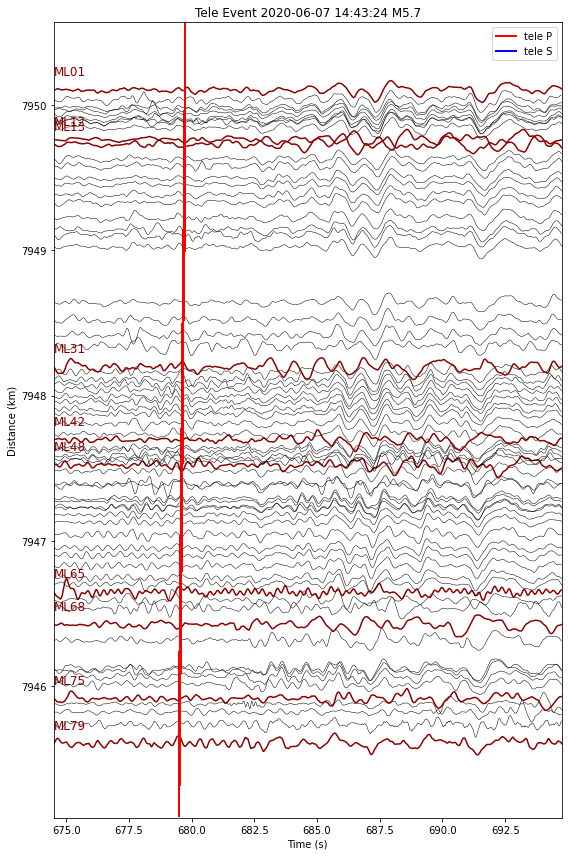

In [10]:
import os
from seisloc.wf.telewf2 import tele_file_plot

time_problem_list = ["ML01","ML12","ML13","ML31","ML42","47",
                     "ML48","ML65","ML68","ML70","ML75","ML79"]

high_list = ["ML01","ML12","ML13","ML31","ML42","47","ML48",
             "ML65","ML68","ML70","ML75","ML79"]
#              "Z230","Z050","Z030","Z140","Z321",
#              "Z102","S004","S006","Z232"]
tmp_high = ["ML01","ML12","ML13","ML31","ML42","47",
            "ML48","ML65","ML68","ML70","ML75","ML79"]
tele_dir = "tele_event"
for tele in os.listdir(tele_dir):           # Loop for each event
    print(tele)
#for tele in ["20200419203905.tele"]:
    tele_file = os.path.join(tele_dir,tele)
    if os.path.isfile(tele_file) and tele[-4:] == "tele":
            tele_file_plot(tele_file,
                          wf_dir = day_data,
                          sta_sel=[],
                          sta_exclude = [],
                          sta_highlight=tmp_high,
                          plot_phase = "P",
                          p_method="dist",
                          bp_range= [0.5,2],
                          x_offsets=[5,15],
                          y_offset_ratio=[0.1,0.1],
                          wf_normalize=True,
                          wf_scale_factor=0.15,
                          label_stas = tmp_high,
                          figsize=(8,12),
                          linewidth=0.5,
                          o_format="png",
                          from_saved_wf=True,
                          save_result_wf=True)  

## Tele-event waveform cross-correlation

  0%|                                                    | 0/35 [00:00<?, ?it/s]

tele_event/20200530130623.tele


  3%|█▎                                          | 1/35 [00:16<09:12, 16.26s/it]

tele_event/20200523230227.tele


  6%|██▌                                         | 2/35 [00:16<03:51,  7.03s/it]

tele_event/20200508204530.tele


  9%|███▊                                        | 3/35 [00:17<02:10,  4.08s/it]

tele_event/20200503115424.tele


 11%|█████                                       | 4/35 [00:18<01:26,  2.78s/it]

tele_event/20200530181347.tele


 14%|██████▎                                     | 5/35 [00:18<00:59,  2.00s/it]

tele_event/20200609045610.tele


 17%|███████▌                                    | 6/35 [00:19<00:43,  1.51s/it]

tele_event/20200506135356.tele


 20%|████████▊                                   | 7/35 [00:19<00:33,  1.20s/it]

tele_event/20200609171814.tele


 23%|██████████                                  | 8/35 [00:20<00:26,  1.01it/s]

tele_event/20200507112119.tele


 26%|███████████▎                                | 9/35 [00:21<00:22,  1.15it/s]

tele_event/20200418092418.tele


 29%|████████████▎                              | 10/35 [00:21<00:18,  1.38it/s]

tele_event/20200609160850.tele


 31%|█████████████▌                             | 11/35 [00:22<00:16,  1.47it/s]

tele_event/20200511010618.tele


 34%|██████████████▋                            | 12/35 [00:22<00:14,  1.59it/s]

tele_event/20200516133752.tele


 37%|███████████████▉                           | 13/35 [00:23<00:13,  1.68it/s]

tele_event/20200607200638.tele


 40%|█████████████████▏                         | 14/35 [00:25<00:25,  1.23s/it]

tele_event/20200526225212.tele


 43%|██████████████████▍                        | 15/35 [00:26<00:20,  1.01s/it]

tele_event/20200518232235.tele


 46%|███████████████████▋                       | 16/35 [00:26<00:16,  1.14it/s]

tele_event/20200603155404.tele


 49%|████████████████████▉                      | 17/35 [00:27<00:14,  1.28it/s]

tele_event/20200504130748.tele


 51%|██████████████████████                     | 18/35 [00:27<00:12,  1.39it/s]

tele_event/20200604084939.tele


 54%|███████████████████████▎                   | 19/35 [00:28<00:10,  1.49it/s]

tele_event/20200613210830.tele


 57%|████████████████████████▌                  | 20/35 [00:28<00:08,  1.78it/s]

tele_event/20200510235833.tele


/home/aqeel/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:86: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
 60%|█████████████████████████▊                 | 21/35 [00:29<00:07,  1.78it/s]

tele_event/20200527070910.tele


 63%|███████████████████████████                | 22/35 [00:29<00:07,  1.79it/s]

tele_event/20200425025305.tele


 66%|████████████████████████████▎              | 23/35 [00:30<00:06,  1.74it/s]

tele_event/20200418082537.tele


 69%|█████████████████████████████▍             | 24/35 [00:30<00:05,  1.96it/s]

tele_event/20200512224112.tele


 71%|██████████████████████████████▋            | 25/35 [00:31<00:05,  1.83it/s]

tele_event/20200419203905.tele


 74%|███████████████████████████████▉           | 26/35 [00:31<00:04,  1.93it/s]

tele_event/20200502125106.tele


 77%|█████████████████████████████████▏         | 27/35 [00:32<00:04,  1.90it/s]

tele_event/20200607143656.tele


 80%|██████████████████████████████████▍        | 28/35 [00:33<00:03,  1.85it/s]

tele_event/20200610042921.tele


 83%|███████████████████████████████████▋       | 29/35 [00:33<00:03,  1.80it/s]

tele_event/20200520234318.tele


 86%|████████████████████████████████████▊      | 30/35 [00:34<00:02,  1.76it/s]

tele_event/20200417163048.tele


 89%|██████████████████████████████████████     | 31/35 [00:34<00:01,  2.15it/s]

tele_event/20200613155124.tele


 91%|███████████████████████████████████████▎   | 32/35 [00:34<00:01,  2.40it/s]

tele_event/20200606105541.tele


 94%|████████████████████████████████████████▌  | 33/35 [00:35<00:00,  2.27it/s]

tele_event/20200516031544.tele


 97%|█████████████████████████████████████████▊ | 34/35 [00:35<00:00,  2.10it/s]

tele_event/20200607144324.tele


100%|███████████████████████████████████████████| 35/35 [00:36<00:00,  1.04s/it]


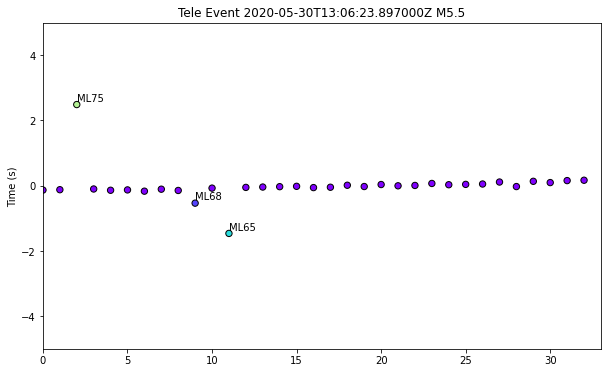

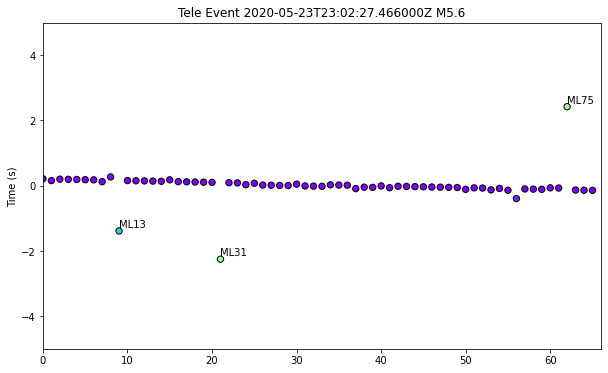

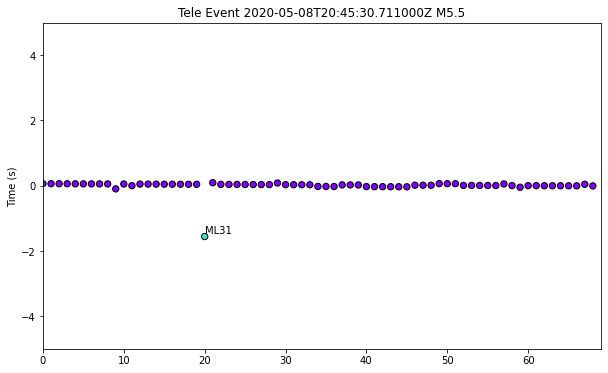

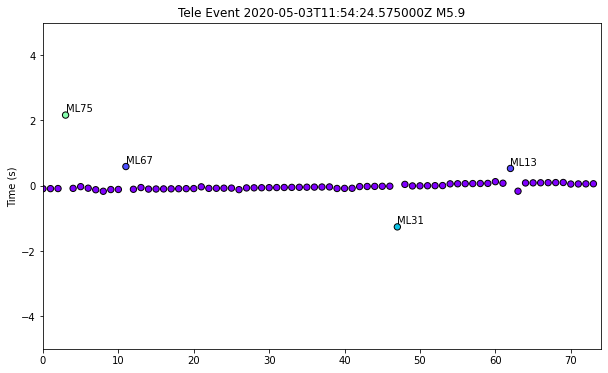

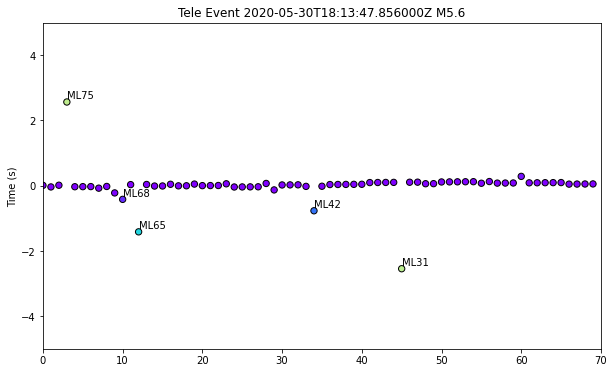

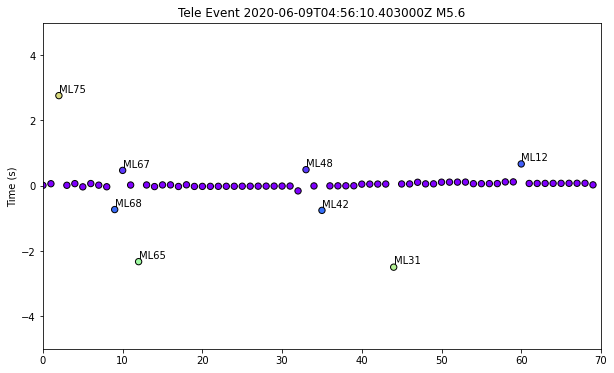

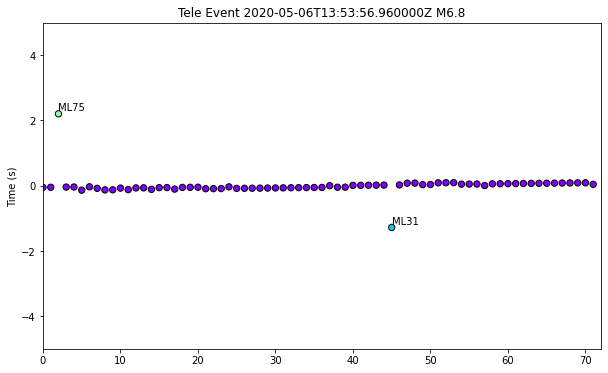

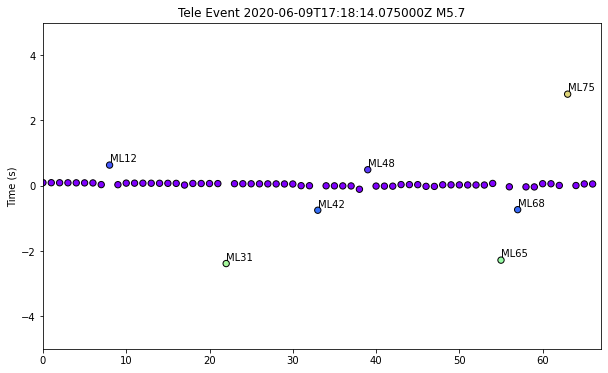

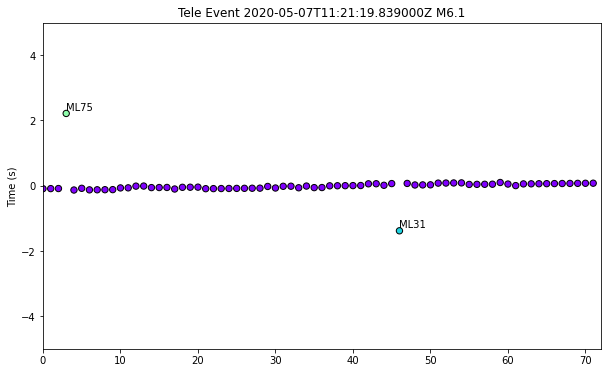

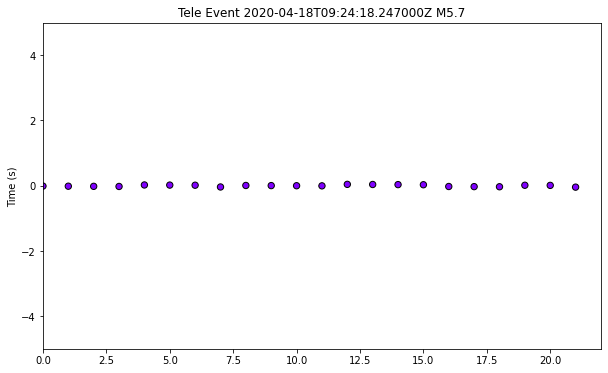

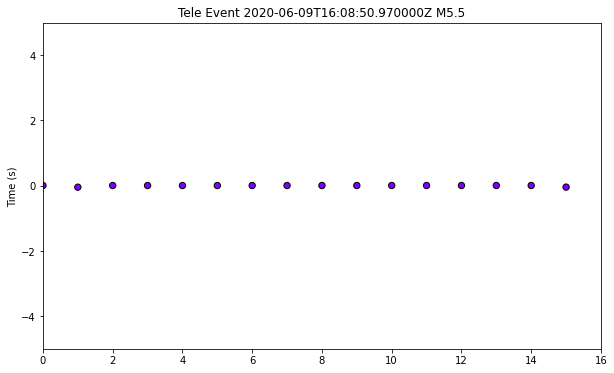

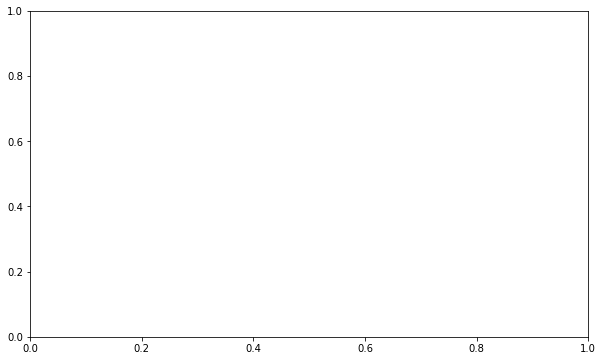

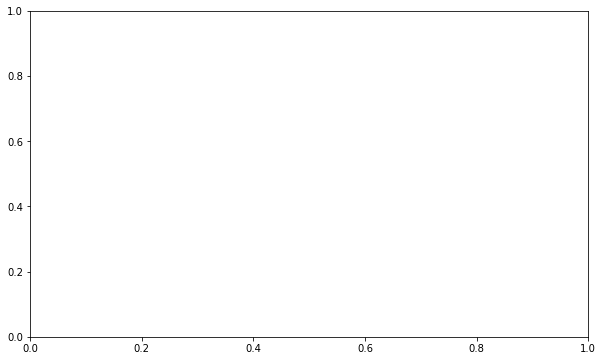

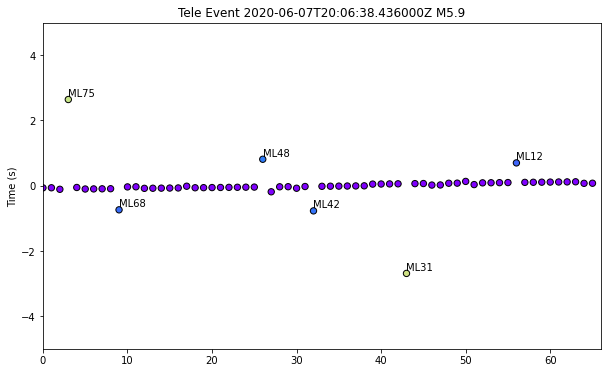

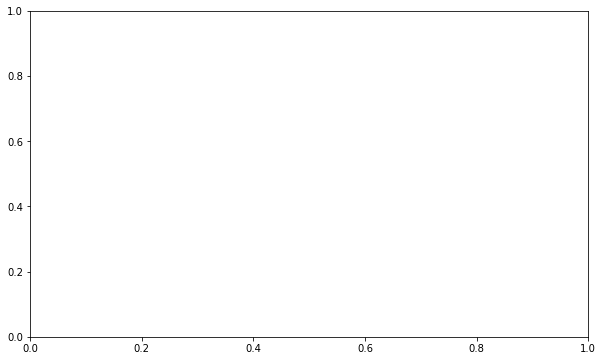

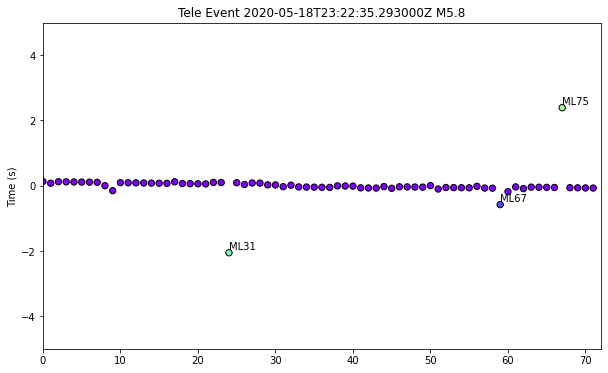

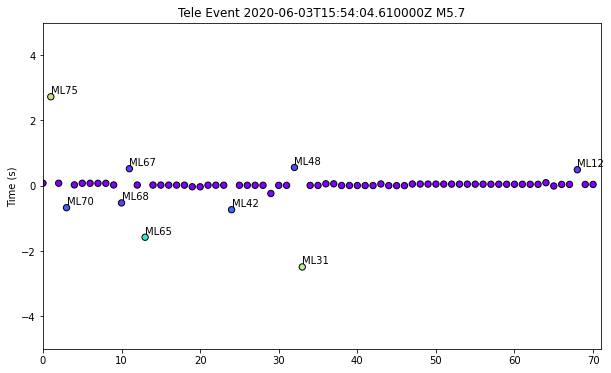

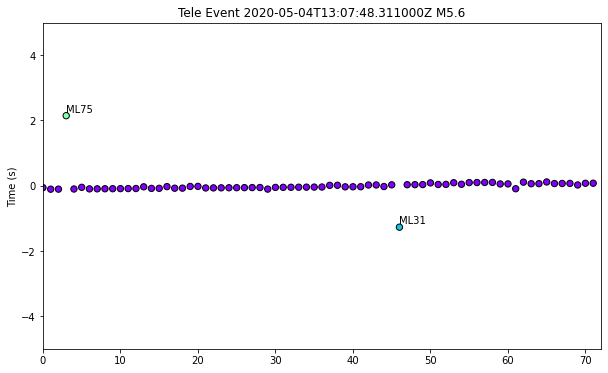

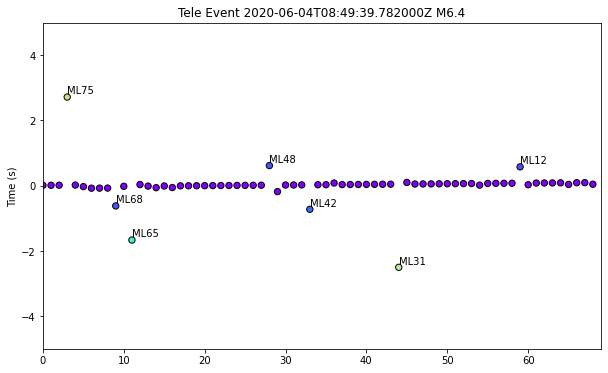

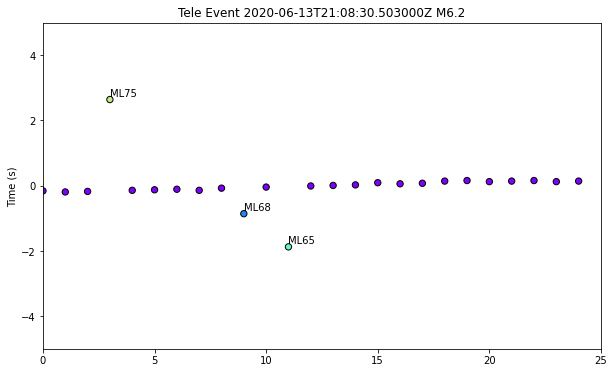

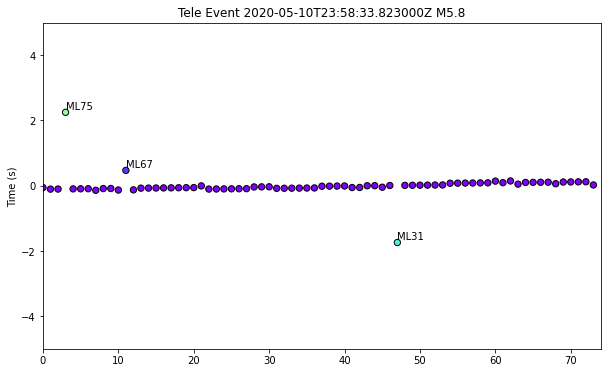

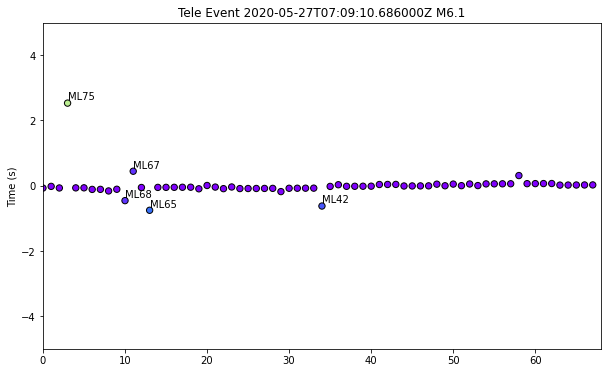

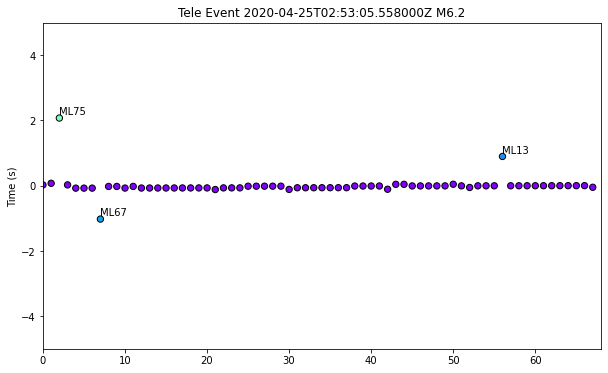

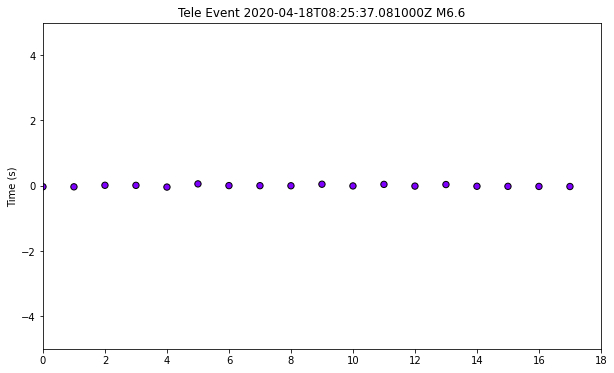

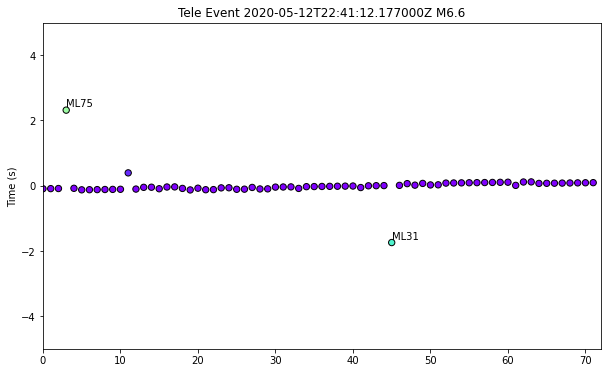

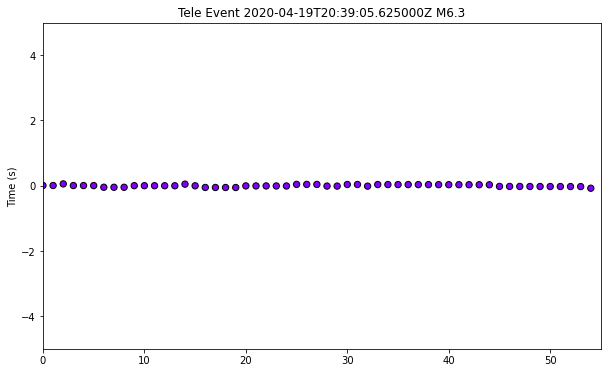

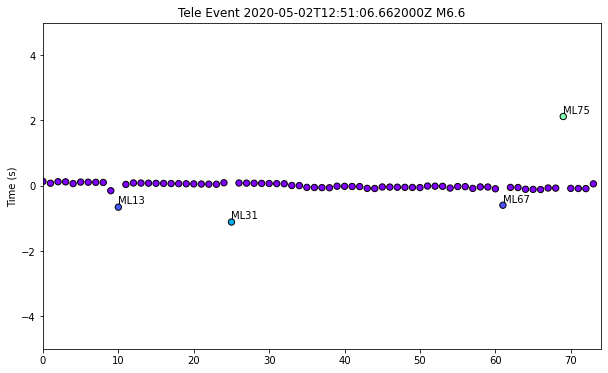

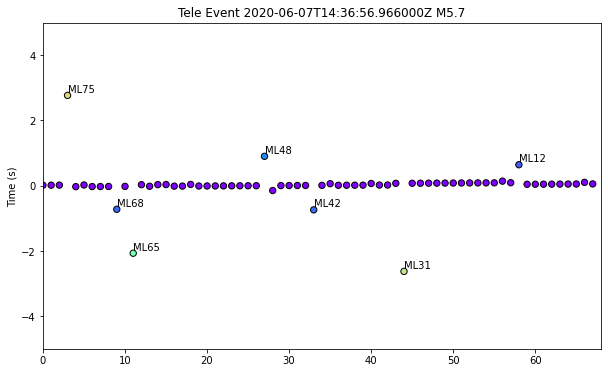

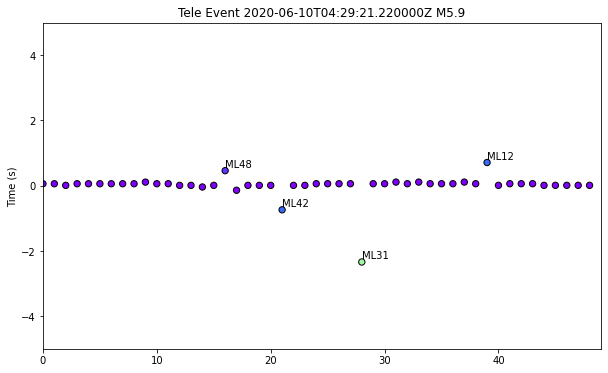

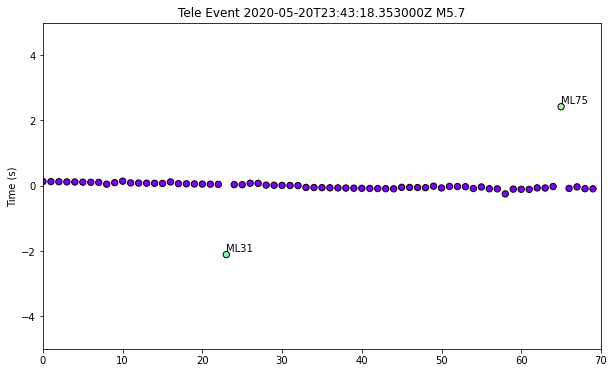

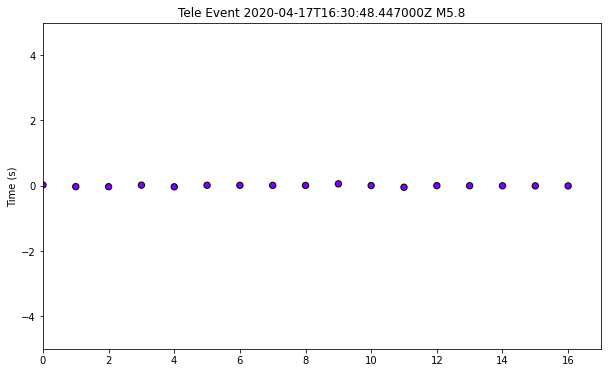

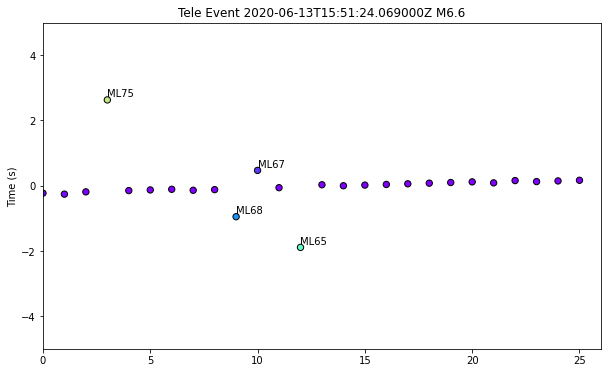

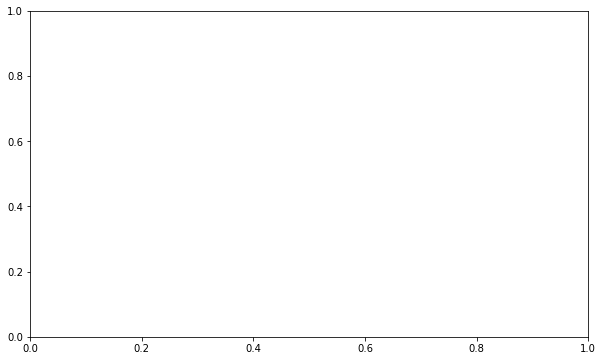

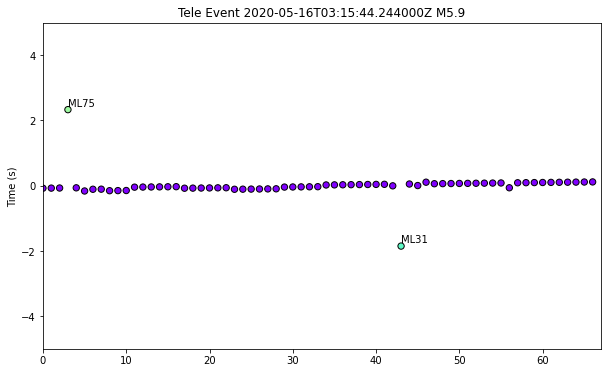

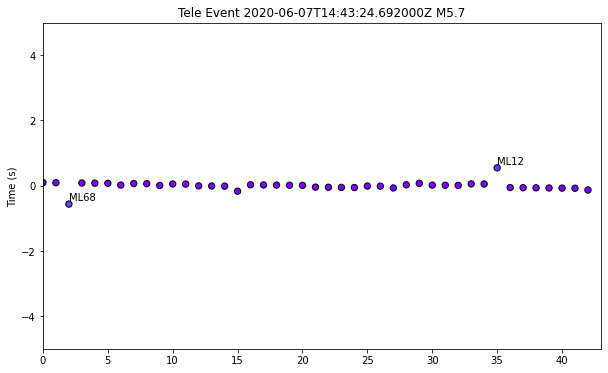

In [11]:
from seisloc.noise import xcorr
import matplotlib.pyplot as plt
import numpy as np
from numpy import polyfit
import glob
import csv
import obspy
from obspy import UTCDateTime
from tqdm import tqdm
import re


def plot_tele_diff(plot_phase="P",tb=-5,te=20,
                   base="tele_event",maxlag=100,
                   freq_range=[0.5,2],decimate_factor=5,
                   figsize=(10,6)):
    """
    This function reads in the corresponding tele event minseed files,
    do cross-correlation to find large shift stations and make plot.
    
    Parameter:
      maxlag: maxlag data points. The total calculation times is 2*maxlag+1
    """

    tele_files = glob.glob(os.path.join(base,"*tele"))
    for tele_file in tqdm(tele_files):
        print(tele_file)
        with open(tele_file,'r') as f:
            lines = f.readlines()
        f.close()

        st = obspy.read(tele_file[:-4]+"mseed")
        st.detrend("linear")
        st.detrend("constant")
        st_new = st.decimate(factor=decimate_factor)
        st_new.filter("bandpass",freqmin=freq_range[0],freqmax=freq_range[1],zerophase=True)

        ref_sta_set =False

        maxtimes = []
        sta_sequence = []
        delta = st_new[0].stats.delta
        
        str_time,_,_,_dep,_mag,type = lines[0].split()
        e_time = UTCDateTime(str_time)
        
        _e_time = re.split(" +",lines[0])[0]
        e_time = UTCDateTime(_e_time)
        for line in lines[1:]:
            
            line = line.rstrip()
            netsta,_p,_s,_dist = line.split()
            net = netsta[:2]
            sta = netsta[2:]
            st_sel = st_new.select(network=net,station=sta,component='*Z')
            if len(st_sel)==0:
                continue
            if plot_phase == "P":
                ttb = e_time + float(_p) + tb
                tte = e_time + float(_p)+ te
            if plot_phase == "S":
                ttb = e_time + float(_s) + tb
                tte = e_time + float(_s)+ te
            if plot_phase == "PS":
                ttb = e_time + float(_p) + tb
                tte = e_time + float(_s)+ te
            st_sel = st_sel.trim(starttime=ttb,endtime=tte)
            sta_tr = st_sel[0]
            if not ref_sta_set:
                ref_sta = sta
                ref_sta_set = True
                continue
            ref_tr = st_new.select(station=ref_sta,component="*Z")[0]
            try:
                corr_result = xcorr(sta_tr.data,ref_tr.data,maxlag)
            except:
                continue
            corr_result = list(corr_result/(np.linalg.norm(sta_tr.data)*np.linalg.norm(ref_tr.data)))
            max_corr = max(corr_result)
            if max_corr < 0.7:
                continue
            max_index = corr_result.index(max_corr)
            maxtimes.append((max_index-maxlag)*delta)
            sta_sequence.append(sta)

        fig,ax = plt.subplots(1,1,figsize=figsize)
        try:
            p = polyfit(np.arange(len(maxtimes)),maxtimes,deg=1)
        except:
            continue
        x = np.linspace(0,len(maxtimes)-1,len(maxtimes))
        y = x*p[0]+p[1]
        diffs = maxtimes-y
        plt.scatter(x,diffs,c=np.abs(diffs),s=40,edgecolor='k',cmap="rainbow",vmin=0.2,vmax=4)
        ev_time=tele_file[11:24]
       # if os.path.exists(f"{ev_time}_M{_mag}.csv"):
         #   os.remove(f"{ev_time}_M{_mag}.csv")     
        with open(f"{ev_time}_M{_mag}.csv","w") as f:
            writer=csv.writer(f,delimiter="\t")
            writer.writerows(zip(x,diffs,sta_sequence))
        f.close()            
#         with open(f"Tele Event_{ev_time}_M{_mag}.csv","at") as f:
#             f.write(f"{x} {diffs}\n")
#         f.close()
        plt.ylim([-5,5])
        plt.xlim([0,len(maxtimes)])
        plt.ylabel("Time (s)")
        for i in range(len(sta_sequence)):
            if np.abs(diffs[i])>0.4:
                plt.text(i,diffs[i]+0.1,sta_sequence[i])
        plt.title(f"Tele Event {e_time} M{_mag}")
        plt.savefig(tele_file[:-4]+"jpg")      
plot_tele_diff()